# Essex Property Trust Price Prediction

In [16]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from optuna import visualization as vis
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [4]:
# Load the data
df = pd.read_csv('../data/final_data.csv')
# sort by date
df = df.sort_values(by='date')
df

,date,State,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
0,2016-12-30,AL,43.000000,-0.556701,52.000000,-0.174603,3.000000,-0.571429,36.000000,0.161290,...,37.555556,-11.831541,1994.000000,-0.005982,0.962797,-0.005236,99.543540,0.022577,1122.650058,216066.470760
22,2016-12-30,NM,114.313585,0.084512,134.713228,0.382836,20.912155,0.233377,49.089377,-0.202766,...,34.912703,3.409213,1581.070352,0.000619,0.968729,-0.003238,123.185945,-0.022682,1000.213260,214940.891096
23,2016-12-30,NV,73.000000,-0.401639,119.000000,-0.201342,11.000000,-0.312500,85.000000,-0.174757,...,22.976471,4.889092,1534.000000,0.009875,0.975629,-0.001425,171.276080,0.051403,1148.605311,305904.466295
24,2016-12-30,NY,151.742276,-0.169707,92.002294,-0.282131,3.498929,0.101171,96.855613,-0.176365,...,33.720803,2.649503,1349.549098,-0.060022,0.969925,0.004392,328.973719,0.029551,1895.798229,456494.835558
25,2016-12-30,OH,148.807790,-0.110787,141.400560,-0.119257,8.218554,0.395212,89.297186,-0.161583,...,30.830572,-0.016809,1560.083967,0.006244,0.960467,0.020897,76.917214,0.094313,843.742553,129419.574891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18425,2024-11-01,MA,97.090933,-0.041412,108.639851,0.122470,22.133546,0.093218,94.045135,0.329857,...,12.019740,-2.424043,1628.974114,0.013848,1.001044,-0.003737,407.260117,0.051139,2594.192374,625927.096790
18426,2024-11-01,MD,95.834211,0.211162,108.185107,0.159219,27.503864,0.048320,85.445557,0.262958,...,12.788671,-0.572449,1767.211363,-0.016668,0.998137,0.001047,221.888798,0.042522,1943.986460,396332.990533
18427,2024-11-01,ME,34.411858,0.313887,39.709881,0.830392,6.226087,0.024200,26.207115,0.097976,...,15.972631,3.528026,1569.513439,0.029284,0.975217,-0.004498,184.368299,0.006300,1536.475750,299791.577634
18416,2024-11-01,GA,25.704628,-0.165583,28.377602,-0.020919,5.882505,0.030047,21.229142,0.355209,...,21.932300,-0.595328,1743.028643,-0.022036,0.970562,-0.001474,159.285000,0.115485,1541.986132,255540.577007


In [5]:
# describe the data
df.describe()

,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,median_new_listing_price_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
count,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,...,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000
mean,224.822185,0.020352,228.979772,0.016517,57.717817,0.265805,190.655146,0.017660,356879.316094,0.077466,...,13.636546,-0.454951,1740.661655,0.010256,0.991642,0.001699,206.673428,0.078572,1515.914613,338363.084043
std,268.399737,0.252885,277.258932,0.293648,75.809862,1.074286,226.218136,0.258654,145058.128008,0.088239,...,6.712299,5.333714,239.320561,0.071756,0.018139,0.014420,117.353164,0.077867,419.397500,147694.948987
min,4.000000,-0.846920,6.000000,-0.911950,0.000000,-1.000000,5.871287,-0.840433,73450.000000,-0.680511,...,2.360043,-92.758503,814.000000,-0.387527,0.900450,-0.089645,55.159332,-0.468836,698.509937,84040.300712
25%,78.000000,-0.109911,82.000000,-0.119166,15.700872,-0.165918,70.003369,-0.130728,255538.988678,0.028102,...,8.962673,-2.758122,1595.991905,-0.024072,0.979629,-0.004696,135.614105,0.031558,1212.348959,229266.392067
50%,147.000227,0.005099,152.890582,-0.011288,32.076813,0.069249,127.582461,-0.007770,316702.743756,0.068650,...,12.272461,-0.297261,1732.524705,0.006440,0.989610,0.001766,169.675033,0.068387,1433.380442,299045.004648
75%,237.769617,0.111253,238.005492,0.104181,66.831753,0.412722,202.562952,0.115053,425760.055916,0.118067,...,16.750018,1.906682,1875.542798,0.039469,1.001578,0.008937,230.560699,0.116866,1757.839478,404140.550752
max,1938.274806,7.306175,2068.905801,13.941223,900.482199,55.000000,2069.351800,3.762365,997500.000000,1.118367,...,117.757692,94.271909,2879.872908,1.105556,1.090251,0.088707,829.763339,1.262682,2910.561059,923341.979821


### Regional Filter

In [6]:
# include only rows where state is either California or Washington
df = df[(df['State'] == 'CA') | (df['State'] == 'WA')]
df

,date,State,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
36,2016-12-30,WA,204.418965,-0.207611,212.651097,-0.244751,59.000302,-0.007422,178.338031,-0.062777,...,12.728302,-0.133441,1764.748440,0.005044,1.000935,0.008768,198.389570,0.128863,1353.784035,349653.898163
3,2016-12-30,CA,612.258489,-0.166035,494.876903,-0.161775,51.993744,-0.202137,449.127889,-0.100053,...,16.392470,1.228898,1565.083335,0.005876,0.987203,0.000618,281.519117,0.052298,1733.103784,424866.748029
77,2017-01-06,WA,248.013923,-0.064950,291.138541,-0.276793,117.224943,-0.061403,231.313123,0.086815,...,9.260636,-2.060815,1742.989632,-0.019540,0.997046,0.006741,199.713876,0.112473,1358.658663,355589.930506
42,2017-01-06,CA,747.257657,-0.073031,653.256018,-0.086655,116.174599,-0.126654,533.480079,-0.033111,...,14.166396,0.140973,1552.412051,0.006431,0.986344,0.001448,281.394758,0.069794,1740.895621,429453.852062
119,2017-01-13,WA,256.647328,-0.009700,308.923774,-0.148468,145.222410,0.104478,219.513882,0.358655,...,9.475460,-5.000135,1761.979401,0.004950,0.995787,0.000726,195.707123,0.090180,1359.347851,355831.683516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18310,2024-10-18,CA,497.763299,0.069887,467.581939,0.125817,84.174654,-0.029601,425.782446,0.112061,...,14.762282,1.695616,1643.832385,0.025401,1.000579,-0.000927,483.999470,0.028471,2668.967550,763102.655481
18402,2024-10-25,WA,172.693857,0.064097,217.219203,0.169964,84.456051,0.106496,249.304481,0.249193,...,11.027499,0.637130,1823.859138,-0.009283,0.992264,0.001180,354.396527,0.051614,1977.263708,610915.621249
18360,2024-10-25,CA,448.478489,-0.059305,459.537713,0.090284,86.421338,0.082381,457.131289,0.188565,...,13.289253,0.452021,1634.338944,0.012376,0.997766,-0.001808,483.171615,0.031278,2665.526894,760999.665713
18452,2024-11-01,WA,156.067062,0.103779,206.177883,0.143892,65.596130,0.229365,202.261453,0.301700,...,13.174977,-0.520094,1828.096801,0.041181,0.992876,0.003316,376.619631,0.054799,1974.242008,625140.177926


### Aggregate Rows by Date

In [7]:
df = utils.process_data(df.drop(columns='State'), utils.features_weighted, groupby='date')
df

,date,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
0,2016-12-30,554.414115,-0.171932,454.848474,-0.173544,52.987493,-0.174521,410.721435,-0.094766,442009.864001,...,15.872776,1.035675,1593.402079,0.005758,0.989151,0.001774,269.728752,0.063157,1679.304404,414199.218288
1,2017-01-06,676.813588,-0.071891,602.160678,-0.113483,116.322804,-0.117447,490.843851,-0.016189,451041.329472,...,13.474186,-0.169703,1579.302845,0.002767,0.987854,0.002195,269.869458,0.075816,1686.961390,419031.537567
2,2017-01-13,644.893426,-0.078692,654.156298,-0.034049,155.127284,0.050054,435.792077,0.102375,456040.273829,...,15.027766,-2.209880,1587.168951,0.010043,0.987059,0.000179,268.377220,0.066502,1682.382269,417593.341691
3,2017-01-20,659.007840,-0.085025,691.659937,-0.143232,156.052896,-0.107219,483.133128,-0.162244,463722.627092,...,13.935507,1.717658,1566.009519,-0.005050,0.990080,0.002402,263.072149,0.072523,1693.727288,421687.744392
4,2017-01-27,714.651845,-0.042475,703.256537,-0.021130,170.723375,-0.028651,522.618803,0.346299,466241.055927,...,12.454856,-5.021336,1598.506636,0.011450,0.988244,0.000384,270.971076,0.078342,1689.846866,421797.247483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2024-10-04,500.995458,0.105776,453.196204,0.221872,86.118287,-0.001794,366.826699,0.211374,750260.557331,...,15.153929,0.828023,1696.223270,0.028630,0.999103,-0.003202,472.109612,0.045555,2538.466091,736688.693354
406,2024-10-11,484.037242,0.102969,441.347476,0.187395,87.953549,0.112873,349.201197,0.024618,758889.727966,...,15.942627,3.311749,1666.305252,0.003029,0.999652,-0.003366,463.540093,0.034025,2540.734838,736617.568277
407,2024-10-18,442.632245,0.091410,422.670694,0.148859,83.262818,0.026642,392.011670,0.142004,755465.796627,...,14.113722,1.401127,1679.602929,0.023989,0.999053,-0.000664,461.128824,0.027073,2541.260966,735481.985721
408,2024-10-25,396.605139,-0.036093,413.959130,0.105272,86.051680,0.086917,418.040377,0.199969,753561.541014,...,12.863831,0.486839,1669.986497,0.008302,0.996731,-0.001246,458.949833,0.035103,2536.068930,732769.803659


### Add AlphaVantage Data

In [8]:
#Read alpha vantage data
file_path_av = "../data/av_data.csv"
df_av = pd.read_csv(file_path_av)
df_av = df_av.drop(columns=['Unnamed: 0'])
df_av

,date,SPY_adj_close,SPY_return_1day,SPY_return_1week,SPY_return_1month,SPY_return_3month,EQR_adj_close,EQR_adj_close_1day,EQR_adj_close_1week,EQR_adj_close_1month,...,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1day,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3monhth_treasury_yield,cpi
0,2017-02-03,201.410539,-0.001788,0.009462,0.036496,0.045656,45.852975,45.989668,47.030055,47.402165,...,148.539775,17.272979,17.356707,17.599516,18.353064,18.018154,0.047,0.000098,0.0065,2.42839
1,2017-02-10,203.316271,0.005443,0.015464,0.027213,0.038761,47.030055,47.189531,46.764263,47.516076,...,149.262275,17.599516,17.582771,17.708362,17.900935,17.959545,0.046,0.000104,0.0066,2.43603
2,2017-02-17,206.460293,0.005955,0.008592,0.011536,0.025677,46.764263,47.402165,48.040066,47.986908,...,149.238969,17.708362,17.976290,18.260964,18.034899,17.941583,0.046,0.000102,0.0066,2.43603
3,2017-02-24,207.909361,0.001563,0.007096,-0.007860,0.016153,47.675551,48.040066,47.326224,48.178335,...,149.137974,18.085136,18.260964,18.260964,18.068390,18.193454,0.046,0.000100,0.0066,2.43603
4,2017-03-03,209.384761,-0.002978,-0.003062,-0.006931,0.017333,47.326224,47.402165,47.052837,47.627201,...,148.633001,18.260964,18.353064,17.917681,18.277709,17.933188,0.046,0.000117,0.0065,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-08-16,552.612504,0.009561,0.014108,0.015389,0.083508,70.775391,70.953791,72.975662,77.078870,...,232.210000,35.000079,35.347302,35.863177,36.478257,33.830000,0.042,0.000999,0.0533,3.14796
382,2024-08-23,560.408556,-0.002384,0.002757,0.016526,0.049502,72.975662,72.281883,74.214553,76.751803,...,229.220000,35.863177,35.545716,36.547702,36.210400,34.150000,0.042,0.000990,0.0533,3.14796
383,2024-08-30,561.953809,-0.020579,-0.030638,0.021009,0.063308,74.214553,74.987622,74.432598,74.460000,...,232.900000,36.547702,36.974290,35.406826,35.260000,33.840000,0.042,0.000979,0.0533,3.14796
384,2024-09-06,538.705224,0.011196,0.040066,0.063624,0.120520,73.679352,74.432598,77.386115,73.530000,...,230.800000,35.664763,35.406826,36.726274,34.540000,33.900000,0.041,0.000968,0.0533,3.15301


In [9]:
df = pd.merge(df, df_av,
              on=["date"],
              how="left")
df.dropna(inplace=True)
df

,date,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1day,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3monhth_treasury_yield,cpi
5,2017-02-03,709.685404,-0.119737,720.005883,-0.047961,180.987245,0.022327,421.209491,0.008467,475660.616728,...,148.539775,17.272979,17.356707,17.599516,18.353064,18.018154,0.047,0.000098,0.0065,2.42839
6,2017-02-10,707.514737,-0.074800,762.801404,-0.019896,186.386196,0.001974,522.031628,0.234482,470921.410683,...,149.262275,17.599516,17.582771,17.708362,17.900935,17.959545,0.046,0.000104,0.0066,2.43603
7,2017-02-17,713.732614,-0.107414,739.998389,-0.104281,180.496498,-0.086735,482.257077,-0.113660,471796.500785,...,149.238969,17.708362,17.976290,18.260964,18.034899,17.941583,0.046,0.000102,0.0066,2.43603
8,2017-02-24,814.894703,-0.092835,790.498468,-0.094623,202.385183,-0.092471,647.153556,0.101944,487216.587024,...,149.137974,18.085136,18.260964,18.260964,18.068390,18.193454,0.046,0.000100,0.0066,2.43603
9,2017-03-03,824.703229,0.003200,808.597635,-0.091901,215.616902,-0.056982,558.711365,0.065437,490705.352236,...,148.633001,18.260964,18.353064,17.917681,18.277709,17.933188,0.046,0.000117,0.0065,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2024-08-16,505.091687,0.110730,443.159856,-0.014616,91.741224,-0.108346,388.175951,0.021739,758449.195068,...,232.210000,35.000079,35.347302,35.863177,36.478257,33.830000,0.042,0.000999,0.0533,3.14796
399,2024-08-23,426.333901,0.032050,462.946335,0.048293,90.338970,-0.141974,466.383370,0.072838,739685.543218,...,229.220000,35.863177,35.545716,36.547702,36.210400,34.150000,0.042,0.000990,0.0533,3.14796
400,2024-08-30,537.114423,0.109485,392.656293,0.030933,74.370896,-0.105866,315.094031,0.084566,768653.091827,...,232.900000,36.547702,36.974290,35.406826,35.260000,33.840000,0.042,0.000979,0.0533,3.14796
401,2024-09-06,546.843739,0.095513,445.436203,0.049800,89.942456,-0.118106,371.844819,0.020441,768070.337225,...,230.800000,35.664763,35.406826,36.726274,34.540000,33.900000,0.041,0.000968,0.0533,3.15301


### Splitting Data

In [11]:
# Split the data into features and target
X = df.drop(columns=['date', 'EQR_adj_close_1day', 'ESS_adj_close_1day', 'AVB_adj_close_1day', 'INVH_adj_close_1day',
                     'EQR_adj_close_1week', 'ESS_adj_close_1week', 'AVB_adj_close_1week', 'INVH_adj_close_1week',
                     'EQR_adj_close', 'ESS_adj_close', 'AVB_adj_close', 'INVH_adj_close', 'EQR_adj_close_1month',
                     'ESS_adj_close_1month', 'AVB_adj_close_1month', 'INVH_adj_close_1month', 'EQR_adj_close_3month',
                     'ESS_adj_close_3month', 'AVB_adj_close_3month', 'INVH_adj_close_3month'])
y = df['ESS_adj_close_1week']

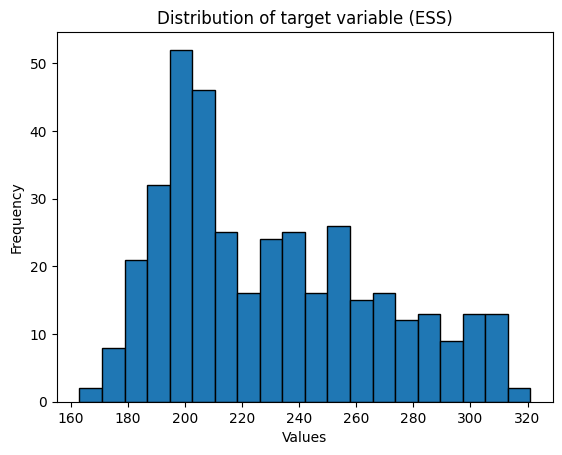

In [13]:
#target variable distribution
plt.hist(y, bins=20, edgecolor='black')
plt.title('Distribution of target variable (ESS)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

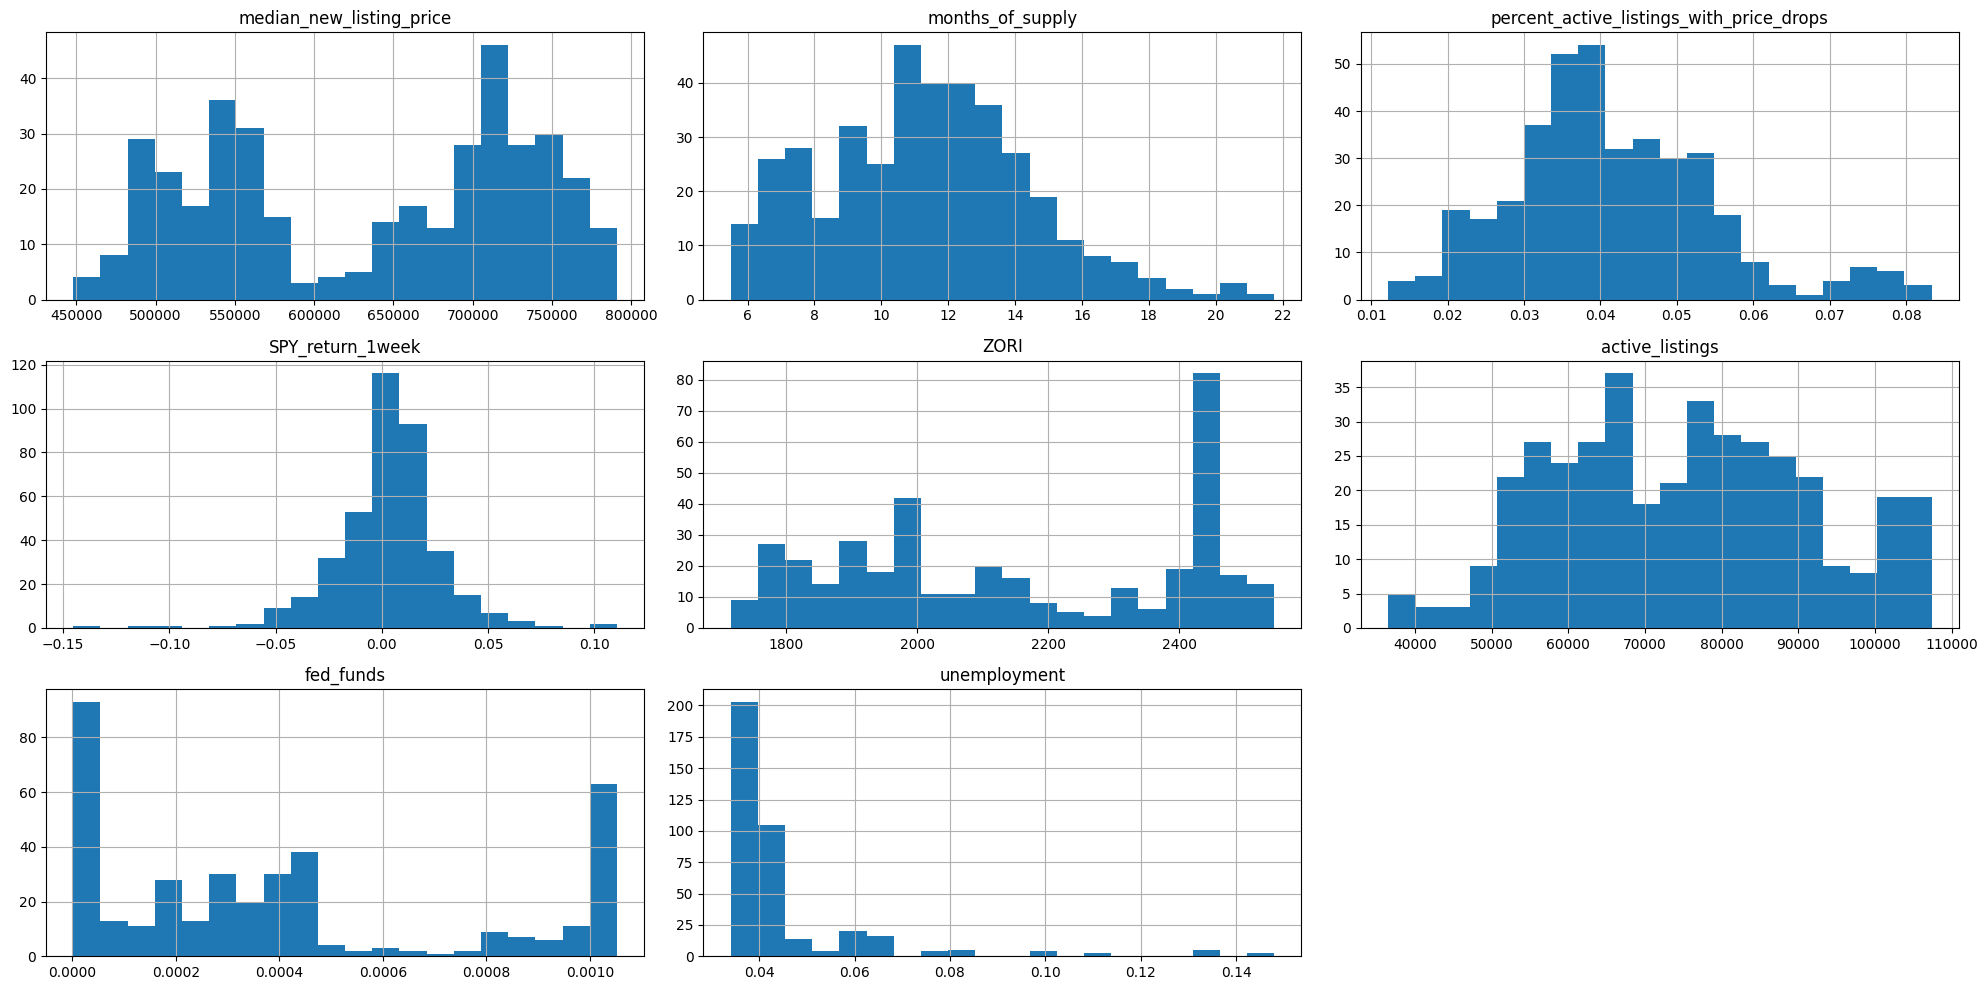

In [14]:
#feature distribution
selected_features = X[["median_new_listing_price", "months_of_supply","percent_active_listings_with_price_drops", "SPY_return_1week", "ZORI", "active_listings", "fed_funds", "unemployment"]]
selected_features.hist(bins=20, figsize=(20, 10))
plt.tight_layout()
plt.show()

<Axes: >

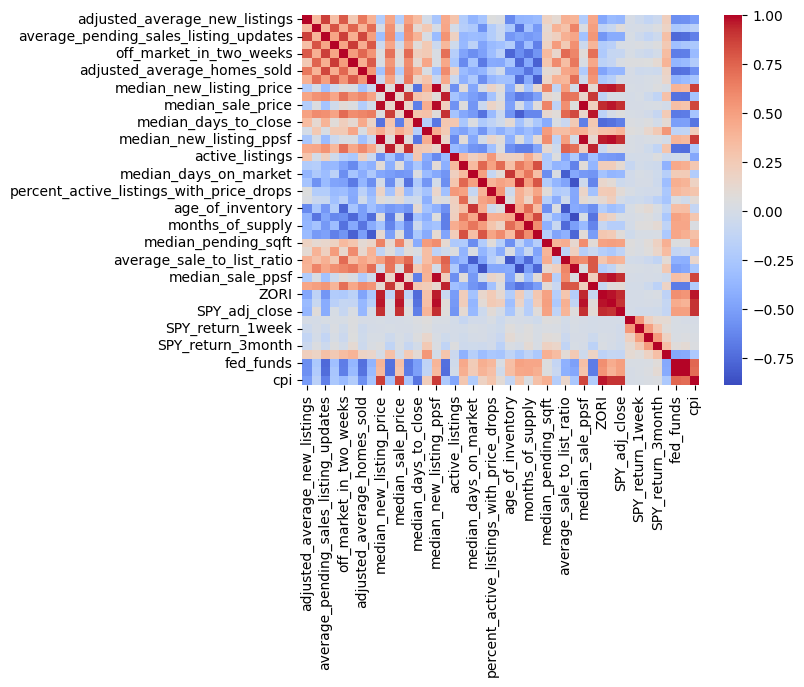

In [17]:
#Correlation
corr = X.corr()
sns.heatmap(corr, annot = False, cmap = "coolwarm")

### Train-Test Split

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Modeling

In [182]:
# define scorer and cross-validation
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=20, shuffle=True, random_state=42)
n_trials = 15

### Random Forest

#### Hyperparameter Tuning

In [183]:
# Hyperparameter search space
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the Random Forest model with suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(rf, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -np.mean(scores)

In [184]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:02:23,320] A new study created in memory with name: rf_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:02:26,195] Trial 0 finished with value: 11.025425380981368 and parameters: {'n_estimators': 295, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 11.025425380981368.
[I 2024-12-11 18:02:26,713] Trial 1 finished with value: 12.23846717582816 and parameters: {'n_estimators': 144, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 11.025425380981368.
[I 2024-12-11 18:02:27,097] Trial 2 finished with value: 14.448448220079547 and parameters: {'n_estimators': 154, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.025425380981368.
[I 2024-12-11 18:02:28,012] Trial 3 finished with value: 15.331935922632468 and parameters: {'n_estimators': 423, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 11.025425380981368.


In [185]:
vis.plot_optimization_history(study_rf).show()
vis.plot_param_importances(study_rf).show()

#### Model Training

In [186]:
# Get the best hyperparameters
best_params_rf = study_rf.best_params

In [187]:
# Create the Random Forest model with best hyperparameters
rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)

In [188]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=None, min_samples_split=6,
                      n_estimators=166, random_state=42)

#### Model Evaluation

In [189]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

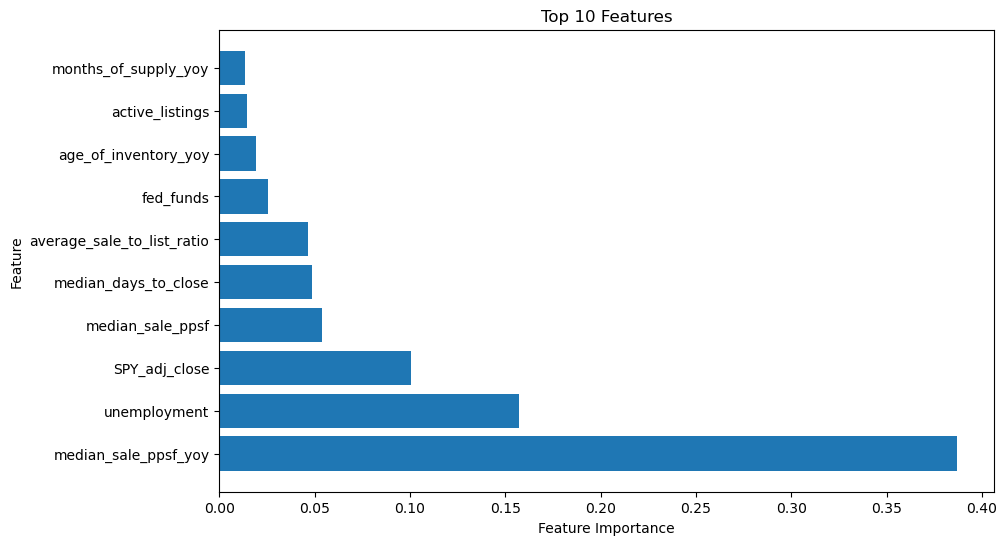

In [190]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(rf.feature_importances_)[::-1][:10]],
         rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

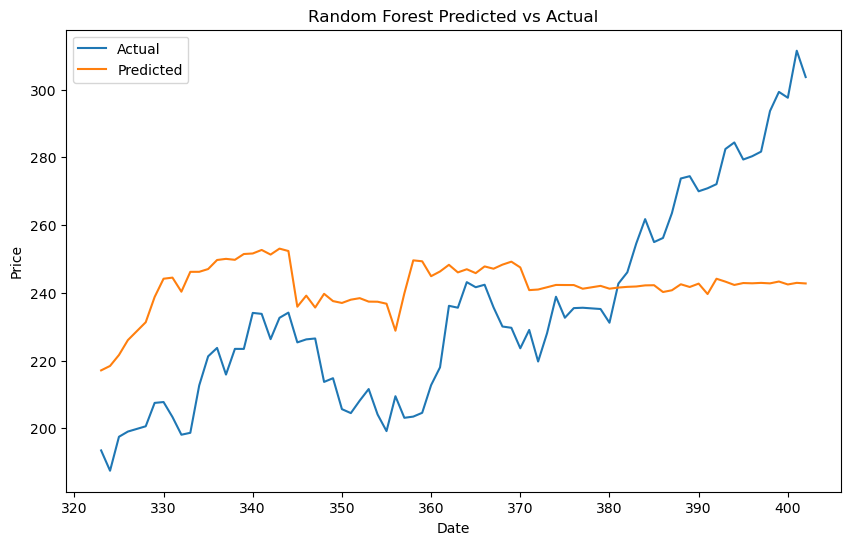

In [191]:
# show predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Random Forest Predicted vs Actual')
plt.legend()
plt.show()

#### Model Saving

In [192]:
# Save the model
pickle.dump(rf, open('../models/ESS_rf.pkl', 'wb'))

### AdaBoost

#### Hyperparameter Tuning

In [193]:
def objective(trial):
    # Hyperparameter search space for the base Decision Tree
    max_depth = trial.suggest_int('max_depth', 1, 2)  # Depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Minimum samples in a leaf node
    max_features = trial.suggest_categorical('max_features',
                                             [None, 'sqrt', 'log2'])  # Features to consider for splitting

    # Hyperparameter search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Define the base estimator (Decision Tree)
    base_estimator = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Define the AdaBoost model
    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [194]:
# Optimize hyperparameters
study_ada = optuna.create_study(direction='minimize', study_name='ada_tuning')
study_ada.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:02:48,826] A new study created in memory with name: ada_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:02:49,001] Trial 0 finished with value: 25.27809813030141 and parameters: {'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'n_estimators': 54, 'learning_rate': 0.3536268325576905}. Best is trial 0 with value: 25.27809813030141.
[I 2024-12-11 18:02:49,076] Trial 1 finished with value: 26.178023909472053 and parameters: {'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.4352530907081255}. Best is trial 0 with value: 25.27809813030141.
[I 2024-12-11 18:02:49,281] Trial 2 finished with value: 25.20377148874635 and parameters: {'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'n_estimators': 302, 'learning_rate': 0.20218157260301506}. Best is trial 2 with value: 25.20377148874635.
[I 2024-12-11 18:02:49,478] Trial 3 finished with value: 26.15037373827668 and parameters: {'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf

In [195]:
# Visualizations
vis.plot_optimization_history(study_ada).show()
vis.plot_param_importances(study_ada).show()

#### Model Training

In [196]:
# Get the best hyperparameters
best_params_ada = study_ada.best_params

In [197]:
# Create the AdaBoost model with best hyperparameters
dt = DecisionTreeRegressor(
    max_depth=best_params_ada['max_depth'],
    min_samples_split=best_params_ada['min_samples_split'],
    min_samples_leaf=best_params_ada['min_samples_leaf'],
    max_features=best_params_ada['max_features'],
    random_state=42
)

ab = AdaBoostRegressor(
    estimator=dt,
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    random_state=42
)

In [198]:
# Fit the model
ab.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=2,
                                                  max_features='sqrt',
                                                  random_state=42),
                  learning_rate=0.8525958341124389, n_estimators=500,
                  random_state=42)

#### Model Evaluation

In [199]:
y_pred_ada_train = ab.predict(X_train)
y_pred_ada_test = ab.predict(X_test)

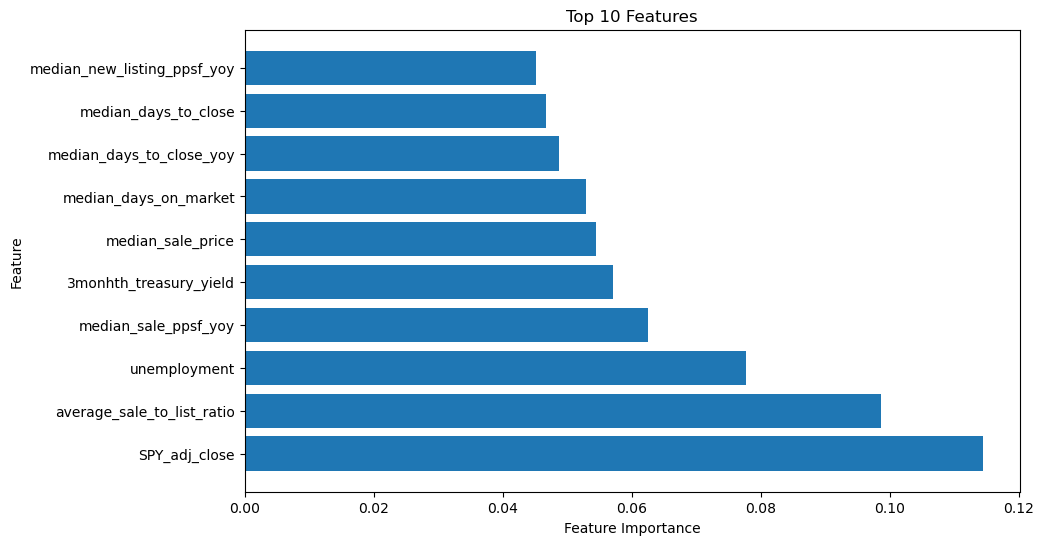

In [200]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(ab.feature_importances_)[::-1][:10]],
         ab.feature_importances_[np.argsort(ab.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

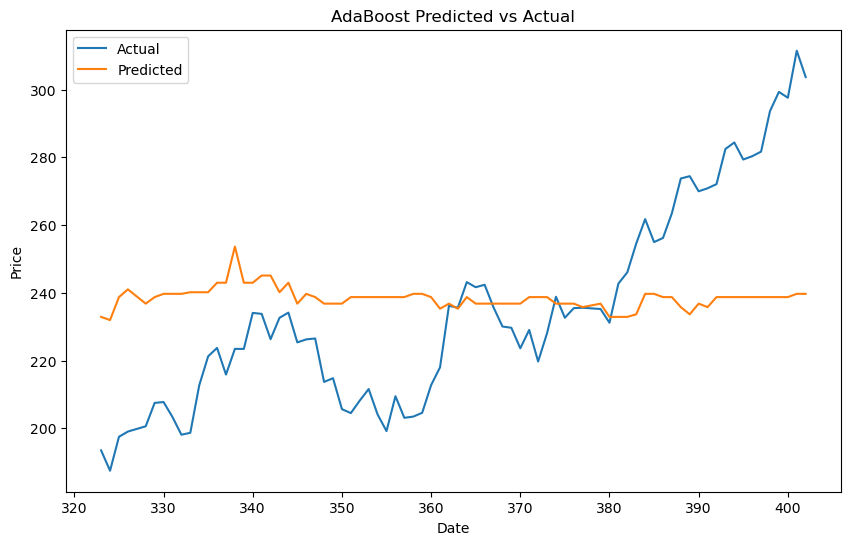

In [201]:
# show predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_ada_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AdaBoost Predicted vs Actual')
plt.legend()
plt.show()

#### Model Saving

In [202]:
# Save the model
pickle.dump(ab, open('../models/ESS_ab.pkl', 'wb'))

### XGBoost

#### Hyperparameter Tuning

In [203]:
# Hyperparameter search space
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),  # L2 regularization
    }

    # Initialize XGBoost model
    model = XGBRegressor(random_state=42, **param)

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [204]:
# Optimize hyperparameters
study_xg = optuna.create_study(direction='minimize', study_name='xg_tuning')
study_xg.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:02:56,895] A new study created in memory with name: xg_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:02:57,821] Trial 0 finished with value: 8.541670850100422 and parameters: {'n_estimators': 274, 'max_depth': 4, 'learning_rate': 0.016056478983893546, 'subsample': 0.50007546383438, 'colsample_bytree': 0.511441837337316, 'gamma': 2.331787110547574, 'min_child_weight': 7, 'reg_alpha': 0.20464600054198812, 'reg_lambda': 0.461657969316529}. Best is trial 0 with value: 8.541670850100422.
[I 2024-12-11 18:02:58,666] Trial 1 finished with value: 9.176471900572608 and parameters: {'n_estimators': 303, 'max_depth': 4, 'learning_rate': 0.2837020867596455, 'subsample': 0.5518594383161242, 'colsample_bytree': 0.733813132194207, 'gamma': 1.8031205197600153, 'min_child_weight': 3, 'reg_alpha': 9.196366760303166, 'reg_lambda': 5.494429191163372}. Best is trial 0 with value: 8.541670850100422.
[I 2024-12-11 18:03:00,843] Trial 2 finished with value: 8.203390409176285 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.020574603332665094, 'subsample': 0.6250464652

In [205]:
# Visualizations
vis.plot_optimization_history(study_xg).show()
vis.plot_param_importances(study_xg).show()

#### Model Training

In [206]:
# Get the best hyperparameters
best_params_xg = study_xg.best_params

In [207]:
# Initialize XGBoost model with best hyperparameters
xgb_model = XGBRegressor(
    random_state=42,
    **best_params_xg
)

In [208]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.585050271201188, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=4.700826687092552,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01119869113690577,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=947, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

In [209]:
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

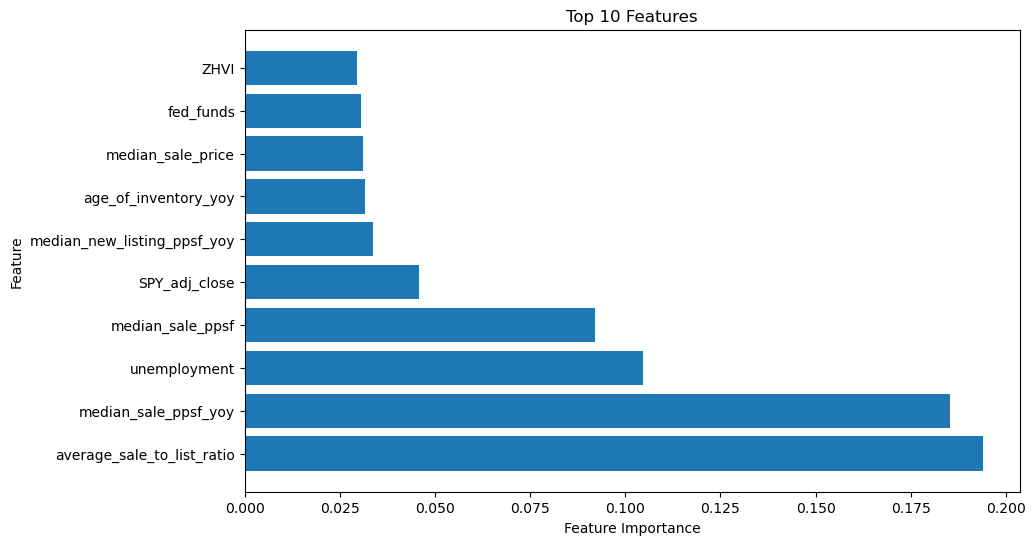

In [210]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(xgb_model.feature_importances_)[::-1][:10]],
         xgb_model.feature_importances_[np.argsort(xgb_model.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

#### Model Saving

In [211]:
# Save the model
pickle.dump(xgb_model, open('../models/ESS_xgb.pkl', 'wb'))

## Conclusion

In [212]:
models = ['Random Forest', 'AdaBoost', 'XGBoost']
predictions_train = [y_pred_rf_train, y_pred_ada_train, y_pred_xgb_train]
predictions_test = [y_pred_rf_test, y_pred_ada_test, y_pred_xgb_test]

utils.evaluate_models(models=models, predictions_train=predictions_train, predictions_test=predictions_test, X=X,
                      y_train=y_train, y_test=y_test, task='regression')

,,Random Forest,AdaBoost,XGBoost
Metric,Type,,,
Mean Absolute Error,Train,2.926174,13.157114,1.692733
Mean Squared Error,Train,16.542883,259.05132,6.002989
Root Mean Squared Error,Train,4.067294,16.095071,2.4501
R-squared,Train,0.989151,0.830117,0.996063
Adjusted R-squared,Train,0.987384,0.802447,0.995422
Mean Absolute Error,Test,25.799421,25.204114,26.401537
Mean Squared Error,Test,871.816031,916.171501,871.930897
Root Mean Squared Error,Test,29.526531,30.268325,29.528476
R-squared,Test,0.01317,-0.037037,0.01304
